In [ ]:
import sys
import os
import json
import numpy as np
import pandas as pd
from importlib import import_module
import seaborn as sns
import matplotlib.pyplot as plt

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

from tVAE_base.tvae_wrapper import TVAESynthesizer
from tVAE_base.local import load_csvs

from sdv.metadata import Metadata, SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdmetrics.single_column import MissingValueSimilarity

In [25]:
datasets = load_csvs(folder_name='/home/mfacotti/martin/tVAE_project')

# Access the rhc.csv data using the filename (without extension) as key
rhc_data = datasets['rhc']

# Display basic information about the loaded data
print(f"Dataset shape: {rhc_data.shape}")
rhc_data.head()

Dataset shape: (5735, 62)


/home/mfacotti/martin/tVAE_project/tVAE_base/local.py:36: UserWarning:

Ignoring incompatible files ['EDA.ipynb', 'README.md', 'test_metadata_fixed.json', '.gitignore', 'numerical_no_na_metadata.json', 'original_metadata.json', 'delete_first_column_rhc.py', 'test_metadata.json', 'test_model_tvae.pkl', 'generated_metadata.json', 'light_metadata.json', 'ctgan_test.ipynb'] in folder '/home/mfacotti/martin/tVAE_project'.



,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,chfhx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [26]:
metadata = SingleTableMetadata()
metadata = Metadata.load_from_json('/home/mfacotti/martin/tVAE_project/original_metadata.json')
metadata.validate()

In [28]:
synthesizer = TVAESynthesizer(
    metadata, # required
    enforce_min_max_values=True, # Control whether the synthetic data should adhere to the same min/max boundaries set by the real data
    enforce_rounding=False, # Control whether the synthetic data should have the same number of decimal digits as the real data
    epochs=500,
    verbose=True,
)

synthesizer.fit(rhc_data)

Loss: 42.391: 100%|██████████| 500/500 [08:58<00:00,  1.08s/it]


In [29]:
synthesizer.get_loss_values()
synthesizer.save(
    filepath='test_model_tvae1.pkl'
)

In [ ]:
synthetic_data = synthesizer.sample(
    num_rows=10000,
    batch_size=100
)

synthetic_data.to_csv('synthetic_data_test1.csv', index=False)

In [36]:
diagnostic = run_diagnostic(
    real_data=rhc_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 62/62 [00:00<00:00, 583.22it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 225.56it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [35]:
quality_report = evaluate_quality(
    rhc_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 62/62 [00:08<00:00,  7.40it/s]|
Column Shapes Score: 91.22%

(2/2) Evaluating Column Pair Trends: |██████████| 1891/1891 [00:18<00:00, 102.90it/s]|
Column Pair Trends Score: 85.04%

Overall Score (Average): 88.13%



Missing Values Percentage Comparison:
         Real Data (%)  Synthetic Data (%)
cat2         79.075850               87.45
adld3p       74.908457               80.60
urin1        52.798605               52.18
dthdte       35.100262               34.51
dschdte       0.017437                0.02


<Figure size 1400x800 with 0 Axes>

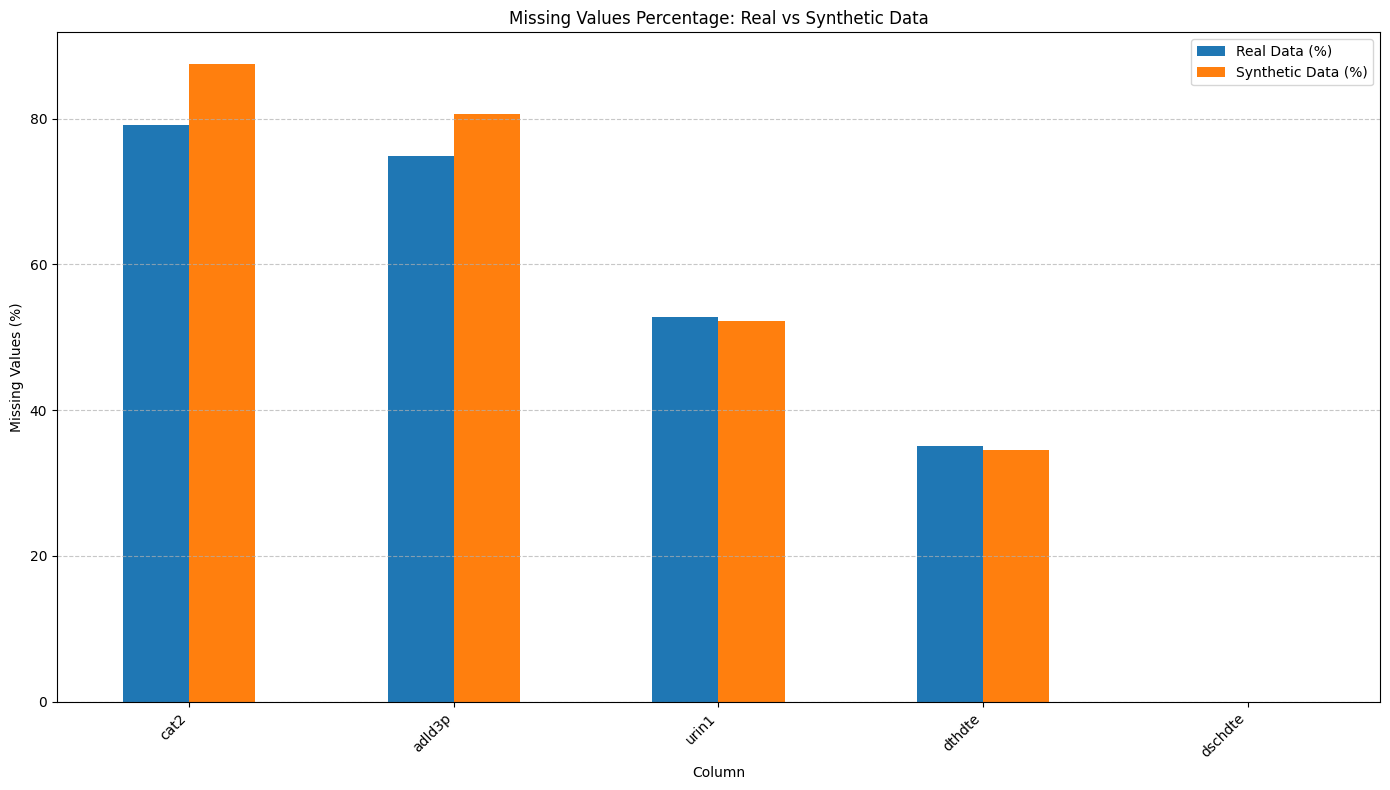

In [ ]:
# Compare missing values percentage between real and synthetic data
missing_real = rhc_data.isna().mean().sort_values(ascending=False) * 100
missing_synthetic = synthetic_data.isna().mean().sort_values(ascending=False) * 100

# Filter only columns with missing values
missing_comparison = pd.DataFrame({
    'Real Data (%)': missing_real[missing_real > 0],
    'Synthetic Data (%)': missing_synthetic.reindex(missing_real[missing_real > 0].index)
})

# Display comparison
print("Missing Values Percentage Comparison:")
print(missing_comparison)

# Visualize the comparison
plt.figure(figsize=(14, 8))
missing_comparison.plot(kind='bar', figsize=(14, 8))
plt.title('Missing Values Percentage: Real vs Synthetic Data')
plt.ylabel('Missing Values (%)')
plt.xlabel('Column')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()